In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from wbfm.utils.projects.finished_project_data import ProjectData
import napari
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
from pathlib import Path
from collections import defaultdict
import zarr
import seaborn as sns

/home/charles/anaconda3/envs/wbfm/lib/python3.7/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


# Functions

In [2]:
def df_from_list(list_of_annotations, col_name_base):
    all_vals = defaultdict(list)
    for proj in list_of_annotations:
        for k, v in proj.items():
            if isinstance(v, list):
                all_vals[k].append(len(v))
                
    all_vals['title'] = [col_name_base] * len(list_of_annotations)

    idx_names = [f'{col_name_base}_{i}' for i in range(len(list_of_annotations))]
    df = pd.DataFrame(all_vals, index=idx_names)
    
    return df

In [3]:
def append_excel_counts_to_dataframe(df_all_datasets, fname, key):
    # New method of loading (append directly to dataframe)
    df = pd.read_excel(fname)
    counts = df['List ID'].value_counts()
    df_all_datasets.loc[key, :] = [int(counts[1]), int(counts[2]), 0, key.split('_')[0]]
    
    return df_all_datasets

# Loading all projects

In [4]:
from wbfm.utils.visualization.load_all_projects import *

ConfigFile  : WARNING  behavior_fname search failed; All calculations with curvature (kymograph) will fail
ConfigFile  : WARNING  behavior_fname search failed; All calculations with curvature (kymograph) will fail
ConfigFile  : WARNING  behavior_fname search failed; All calculations with curvature (kymograph) will fail
ConfigFile  : WARNING  behavior_fname search failed; All calculations with curvature (kymograph) will fail
ConfigFile  : WARNING  behavior_fname search failed; All calculations with curvature (kymograph) will fail
ConfigFile  : WARNING  behavior_fname search failed; All calculations with curvature (kymograph) will fail
ConfigFile  : WARNING  behavior_fname search failed; All calculations with curvature (kymograph) will fail


# Manually annotate which neurons show high, low, or possible activity

High - Can almost certainly get good behavioral correlations. May still show motion artifacts

Low - Probably can't do good correlation based work, but might after additional cleanup. Show low signal, significant artifacts, or lots of gaps

Possible - Can't do work with this without significant cleanup. May be entirely artifact

Also: a description of the level of motion artifacts. 0 = Not visible (none of the datasets); 1 = Low (Many neurons seem undisturbed by artifacts, but they are clear in low signal ones); 2 = Medium (Even neurons with signal have visible artifacts, but they are clearly lower amplitude); 3 = High (Even highest signal neurons have comparible artifacts)

## Original dim

In [5]:
project1_active = dict(
    high = [1, 41, 111, 7, 17, 22, 27, 117, 28, 33, 118, 128, 20],
    low = [6, 16, 21, 36, 71, 47, 122, 142, 13, 68, 105],
    possible = [26, 76, 91, 116, 141, 12, 57, 102, 107, 83, 123, 29, 54, 59, 69, 74, 15, 25, 55, 60, 120, 125],
    motion_artifact_level = 1)

project2_active = dict(
    high = [61, 87, 102, 128, 4, 103, 80],
    low = [66, 62, 97, 3, 8, 93, 108, 118, 9, 24, 34, 93, 74, 94, 15, 40, 95],
    possible = [7, 1, 6, 21, 26, 12, 147, 13, 38, 58, 68, 64, 79, 114, 20, 45, 70, 160],
    motion_artifact_level = 1)


project4_active = dict(
    high = [83],
    low = [88, 103, 119, 40, 70, 65, 130],
    possible = [113, 140, 65, 14, 117],
    motion_artifact_level = 2)

annotations = [project1_active, project2_active, project4_active]
df_dim = df_from_list(annotations, 'original_laser600')

In [6]:
# df_dim

In [7]:
# Not manually annotated

# Round 2 worm 3
project3_active = dict(
    high = [76, 121, 22, 32, 62, 143, 4, 59, 134, 75],
    low = [11, 16, 56, 91, 126, 17, 8, 29, 34, 39, 84, 84, 94, 129, 139, 5, 35, 40, 85],
    possible = [2, 52, 82, 132, 13, 33, 43, 63, 68, 103, 108, 99, 25, 140, 125],
    motion_artifact_level = 1)

# round2 worm4
project5_active = dict(
    high = [30, ],
    low = [1, 138, 24, 138, 64, 15, 85, 145, 155],
    possible = [],
    motion_artifact_level = 1)

# round2 worm4_1
project6_active = dict(
    high = [72, 19],
    low = [11, 136, 57, 63, 19, 64, 124, 135],
    possible = [],
    motion_artifact_level = 1)


annotations = [project1_active, project2_active, project3_active, project4_active, project5_active, project6_active]
df_dim_all = df_from_list(annotations, 'original_laser600')

## Old bright

In [8]:
project_bright1_active = dict(
    high = [1, 46, 26, 72, 117, 8, 23, 33, 38, 29, 39, 139, 55, ],
    low = [6, 11 , 31, 36, 51, 61, 66, 106, 116, 136, 32, 102, 112, 122, 147, 13, 18, 128, 9, 19, 24, 34, 54, 79, 94, 20, 35, 40, 45, 50, 70, 95, 110, 120, 125, 140, 135, 145],
    possible = [31, 7, 47],
    motion_artifact_level = 1)

project_bright2_active = dict(
    high = [41, 91, 2, 62, 146, 20],
    low = [16, 21, 56, 61, 71, 136, 27, 32, 57, 77, 87, 68, 73, 78, 133, 4, 94, 99, 114, 40, ],
    possible = [103, 65, 85, 100, 115, 120, 145, 1, 7, 22, 31, 81, 126, 17, 8, 138],
    motion_artifact_level = 3)

annotations = [project_bright1_active, project_bright2_active]
df_bright = df_from_list(annotations, 'december_laser800')

In [9]:
# Not manually annotated

# Bright6
project_bright3_active = dict(
    high = [6, 26, 61, 61, 116, 102, 33, 43, 78, 108, 4, 39, 109, 70, 140, 4],
    low = [86, 71, 111, 121, 141, 2, 27, 22, 77, 112, 137, 58, 108, 14, 24, 29, 34, 44, 94, 119, 10, 20, 25, 35, 30, 45, 55, 60, 90, 100, 105, 135],
    possible = [],
    motion_artifact_level = 1)

annotations = [project_bright1_active, project_bright2_active, project_bright3_active]
df_bright_all = df_from_list(annotations, 'december_laser800')

## New bright

In [10]:
# None manually annotated

project_bright_C1_active = dict(
    high = [138, 13, 86, ],
    low = [41, 112, 113, ],
    possible = [],
    motion_artifact_level = 1)

project_bright_C2_active = dict(
    high = [7, 22, 68, 83, 19, 105, 135, 59],
    low = [73, 98, 54, 74, 69, 35, 70, 100, 140],
    possible = [],
    motion_artifact_level = 2)

project_bright_C3_active = dict(
    high = [17, 38, 64, ],
    low = [6, 31, 72, 56, 103, 4, 25, 100, 125],
    possible = [],
    motion_artifact_level = 1)

project_bright_C4_active = dict(
    high = [11, 26, 86, 17, 62, 3, 8, 64, 25, 60, ],
    low = [6, 16, 96, 111, 47, 33, 4, 29, 49, 89, 104, 129, 75, 95, 100, 120],
    possible = [],
    motion_artifact_level = 1)


annotations = [project_bright_C1_active, project_bright_C2_active, project_bright_C3_active, project_bright_C4_active]
df_bright_new = df_from_list(annotations, 'new_laser800')

# Exposure 12ms

In [11]:
project_12exp1_active = dict(
    high = [111, 126, 48, 44, 54, 59, 119, 25, 40, 45, 50],
    low = [6, 141, 7, 22, 92, 127, 142, 123, 109, 35, 105, 135],
    possible = [],
    motion_artifact_level = 1)

project_12exp2_active = dict(
    high = [11, 41, 71, 96, 116, 106, 7, 17, 3, 43, 53, 58, 63, 143, 9, 14, 19, 24, 29, 74, 85],
    low = [26, 36, 46, 81, 91, 136, 146, 2, 12, 42, 67, 72, 38, 28, 73, 108, 153, 4, 79, 124, 10, 20, 65, 90, 95, 120, 130, 150],
    possible = [],
    motion_artifact_level = 1)

project_12exp3_active = dict(
    high = [46, 61, 81, 122, 3, 28, 118, 49, 74, 135],
    low = [6, 36, 96, 101, 126, 52, 57, 97, 8, 58, 63, 9, 4, 104, 94, 119, 144, 20, 10, 5, 40, 25, 75, 90, 100, 145, 155],
    possible = [],
    motion_artifact_level = 1)

project_12exp4_active = dict(
    high = [16, 66, 91, 7, 42, 18, 33, 63, 93, 133, 79, ],
    low = [21, 26, 121, 126, 72, 82, 97, 157, 147, 43, 48, 58, 68, 73, 143, 4, 9, 14, 104, 99, 5, 25, 125, 120],
    possible = [],
    motion_artifact_level = 1)

project_12exp6_active = dict(
    high = [21, 31, 76, 131, 186, 115, 10, 85, 94],
    low = [11, 56, 96, 151, 196, 127, 172, 182, 207, 3, 18, 53, 88, 163, 4, 134, 10, 85, 75, 60, ],
    possible = [],
    motion_artifact_level = 2)

project_12exp11_active = dict(
    high = [46, 56, 81, 106, 17, 47, 57, 97, 122, 157, 13, 23, 58, 83, 39, 44, 59, 69, 30, 80, 100, 110],
    low = [16, 86, 146, 32, 72, 82, 132, 8, 68, 78, 98, 4, 14, 64, 74, 139, 30, 15, 105],
    possible = [],
    motion_artifact_level = 1)

project_12exp12_active = dict(
    high = [31, 66, 106, 121, 22, 37, 23, 33, 63, 118, 14, 84, 119, 5, 35, 40, 75, 85, 90, 95, 130, 119],
    low = [1, 6, 56, 61, 81, 101, 141, 2, 7, 67, 82, 87, 92, 97, 152, 3, 8, 48, 93, 4, 49, 79, 84, 94, 25, 30, 50, 80, 140],
    possible = [],
    motion_artifact_level = 1)

annotations = [project_12exp1_active, project_12exp2_active, project_12exp3_active, project_12exp4_active, project_12exp6_active, project_12exp11_active, project_12exp12_active]
df_exp12 = df_from_list(annotations, 'exp12')

In [12]:
project_12exp3_active = dict(
    high = [],
    low = [],
    possible = [],
    motion_artifact_level = 1)

# Double gcamp

In [13]:
project_1_2gcamp_6ms = dict(
    high = [101, 111, 121, 126, 7, 12, 87, 97, 137, 78, 123, 34, 59, 84, 94, 104, 159, 10, 35, 75, 80, 130],
    low = [1, 11, 16, 21, 26, 31, 92, 43, 44, 69, 74, 79, 15, 65, 110, 125],
    possible = [],
    motion_artifact_level = 1)

project_2_2gcamp_6ms = dict(
    high = [61, 86, 136, 2, 17, 23, 28, 98, 113, 4, 29, 49, 59, 84, 15, 75, 100, 110, 130],
    low = [1, 11, 21, 26, 101, 111, 146, 7, 27, 118, 163, 9, 50, 55, 80],
    possible = [],
    motion_artifact_level = 1)


annotations = [project_1_2gcamp_6ms, project_2_2gcamp_6ms]
df_2gcamp_6ms = df_from_list(annotations, 'gcamp2_exp6')

In [14]:
project_1_2gcamp_12ms = dict(
    high = [6, 16, 61, 76, 81, 86, 91, 116, 121, 32, 72, 28, 53, 4, 19, 39, 10, 30, 35, 40, 45, 70, 90, 115],
    low = [11, 51, 56, 66, 37, 102, 137, 38, 83, 118, 74, 114, 134, 5, 25, 65, 110],
    possible = [],
    motion_artifact_level = 1)

project_2_2gcamp_12ms = dict(
    high = [1, 2, 27, 102, 117, 18, 4, 49, 84, 35, 90, 105, 130, 34],
    low = [6, 51, 106, 111, 42, 47, 127, 142, 172, 83, 103, 9, 59, 89, 139, 55, 85, 110],
    possible = [],
    motion_artifact_level = 1)


annotations = [project_1_2gcamp_12ms, project_2_2gcamp_12ms]
df_2gcamp_12ms = df_from_list(annotations, 'gcamp2_exp12')

# Gcamp7b

In [27]:
project_1_gcamp7b = dict(
    high = [6, 31, 36, 91, 111, 136, 176, 32, 57, 67, 87, 92, 18, 94, 35, 65, 85],
    low = [1, 51, 101, 92, 102, 132, 3, 68, 223, 80, 125, 150, 200],
    possible = [],
    motion_artifact_level = 1)

project_data3_gcamp7b = dict(
    high = [6, 41, 46, 66, 71, 81, 111, 116, 2, 12, 32, 47, 57, 117, 3, 23, 58, 68, 98, 133, 29, 39, 79, 10, 30, 35, 55, 60, 85, 95],
    low = [1, 61, 146, 17, 27, 77, 87, 97, 122, 147, 142, 53, 78, 83, 123, 153, 4, 9, 54, 109, 114, 5, 45, 80, 125, 135 ],
    possible = [],
    motion_artifact_level = 1)

project_data4_gcamp7b = dict(
    high = [36, 51, 66, 86, 101, 17, 27, 32, 42, 52, 67, 82, 92, 97, 102, 3, 38, 68, 78, 93, 113, 143, 9, 24, 34, 79, 99, 144, 10, 15, 35, 95, 150],
    low = [16, 21, 26, 12, 107, 58, 88, 138, 4, 30, 20, 140],
    possible = [],
    motion_artifact_level = 1)

project_data5_gcamp7b = dict(
    high = [36, 51, 61, 81, 156, 7, 12, 42, 67, 87, 122, 132, 3, 18, 9, 14, 15, 55, 75, 135],
    low = [6, 31, 126, 151, 17, 37, 48, 58, 153, 24, 69, 99, 159, 40, 115, 140, 150],
    possible = [],
    motion_artifact_level = 1)

In [28]:
annotations = [project_1_gcamp7b, project_data3_gcamp7b, project_data4_gcamp7b, project_data5_gcamp7b]
df_gcamp7b = df_from_list(annotations, 'gcamp7b')

# New method of loading (append directly to above)
fname = "/scratch/neurobiology/zimmer/Charles/dlc_stacks/gcamp7b_sharpened/ZIM2165_Gcamp7b_worm6-2022_10_14_sharpened_1_10/visualization/selected_neurons.xlsx"
key = 'gcamp7b_4'
df_gcamp7b = append_excel_counts_to_dataframe(df_gcamp7b, fname, key)

fname = "/scratch/neurobiology/zimmer/Charles/dlc_stacks/gcamp7b_sharpened/ZIM2165_Gcamp7b_worm7-2022_10_14_sharpened_1_10/visualization/selected_neurons.xlsx"
key = 'gcamp7b_5'
df_gcamp7b = append_excel_counts_to_dataframe(df_gcamp7b, fname, key)

fname = "/scratch/neurobiology/zimmer/Charles/dlc_stacks/gcamp7b_sharpened/ZIM2165_Gcamp7b_worm9-2022_10_14_sharpened_1_10/visualization/selected_neurons.xlsx"
key = 'gcamp7b_6'
df_gcamp7b = append_excel_counts_to_dataframe(df_gcamp7b, fname, key)

# With spacer

In [41]:
df_gcamp7b_spacer_dict = dict()

# New method of loading (append directly to above)
fname = "/scratch/neurobiology/zimmer/Charles/dlc_stacks/with_spacer/worm1-2022_11_22/visualization/selected_neurons.csv"
key = 'gcamp7b_spacer1'
counts = pd.read_csv(fname)['List ID'].value_counts()
df_gcamp7b_spacer_dict[key] = [int(counts[1]), int(counts[2]), 0, 'gcamp7b_spacer']

fname = "/scratch/neurobiology/zimmer/Charles/dlc_stacks/with_spacer/worm3-2022_11_22/visualization/selected_neurons.csv"
key = 'gcamp7b_spacer2'
counts = pd.read_csv(fname)['List ID'].value_counts()
df_gcamp7b_spacer_dict[key] = [int(counts[1]), int(counts[2]), 0, 'gcamp7b_spacer']

fname = "/scratch/neurobiology/zimmer/Charles/dlc_stacks/with_spacer/worm4-2022_11_22/visualization/selected_neurons.csv"
key = 'gcamp7b_spacer3'
counts = pd.read_csv(fname)['List ID'].value_counts()
df_gcamp7b_spacer_dict[key] = [int(counts[1]), int(counts[2]), 0, 'gcamp7b_spacer']

#
df_gcamp7b_spacer = pd.DataFrame(df_gcamp7b_spacer_dict).T
df_gcamp7b_spacer.columns = ['high', 'low', 'possible', 'title']

# New dataset here

In [42]:
df_gcamp7b_spacer

,high,low,possible,title
gcamp7b_spacer1,11,11,0,gcamp7b_spacer
gcamp7b_spacer2,51,34,0,gcamp7b_spacer
gcamp7b_spacer3,50,15,0,gcamp7b_spacer


In [43]:
df_gcamp7b

,high,low,possible,title
gcamp7b_0,17.0,13.0,0.0,gcamp7b
gcamp7b_1,30.0,26.0,0.0,gcamp7b
gcamp7b_2,33.0,12.0,0.0,gcamp7b
gcamp7b_3,20.0,17.0,0.0,gcamp7b
gcamp7b_4,43.0,30.0,0.0,gcamp7b
gcamp7b_5,43.0,30.0,0.0,gcamp7b
gcamp7b_6,43.0,30.0,0.0,gcamp7b


# Individual bar plots

(0.0, 40.0)

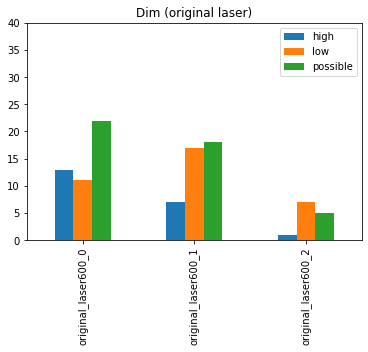

In [44]:
df_dim.plot(kind='bar')
plt.title("Dim (original laser)");
plt.ylim([0, 40])

(0.0, 40.0)

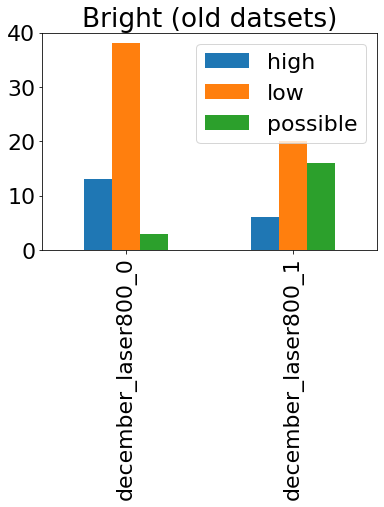

In [54]:
df_bright.plot(kind='bar')
plt.title("Bright (old datsets)");
plt.ylim([0, 40])

(0.0, 40.0)

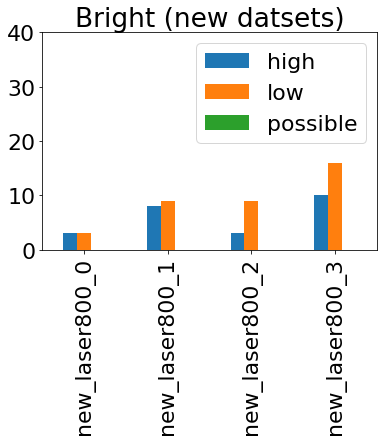

In [55]:
df_bright_new.plot(kind='bar')
plt.title("Bright (new datsets)");
plt.ylim([0, 40])

(0.0, 40.0)

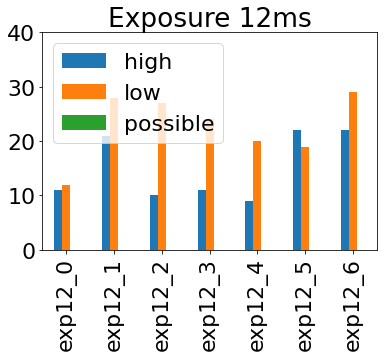

In [56]:
df_exp12.plot(kind='bar')
plt.title("Exposure 12ms");
plt.ylim([0, 40])

# Multiclass box plots

First, only include manually annotated data

In [23]:
import seaborn as sns
import matplotlib
matplotlib.rcParams.update({'font.size': 22})


In [58]:
df_manual = pd.concat([df_dim, df_bright])

In [24]:
# plt.figure(figsize=(15, 15))
# to_plot = 'high'

# sns.barplot(data=df_manual, y=to_plot, x='title')
# sns.scatterplot(data=df_manual, y=to_plot, x='title', legend=False, zorder=10, color='k')
# plt.xlabel("Type of dataset")
# plt.ylabel(f"Number of {to_plot} activity neurons")
# plt.title("Only manually annotated datasets")

In [25]:
# plt.figure(figsize=(15, 15))
# to_plot = 'low'

# sns.barplot(data=df_manual, y=to_plot, x='title')
# sns.scatterplot(data=df_manual, y=to_plot, x='title', legend=False, zorder=10, color='k')
# plt.xlabel("Type of dataset")
# plt.ylabel(f"Number of {to_plot} activity neurons")
# plt.title("Only manually annotated datasets")

## Same, but include non manually annotated data

In [26]:
df_all = pd.concat([df_dim_all, df_bright_all, df_bright_new, df_exp12])

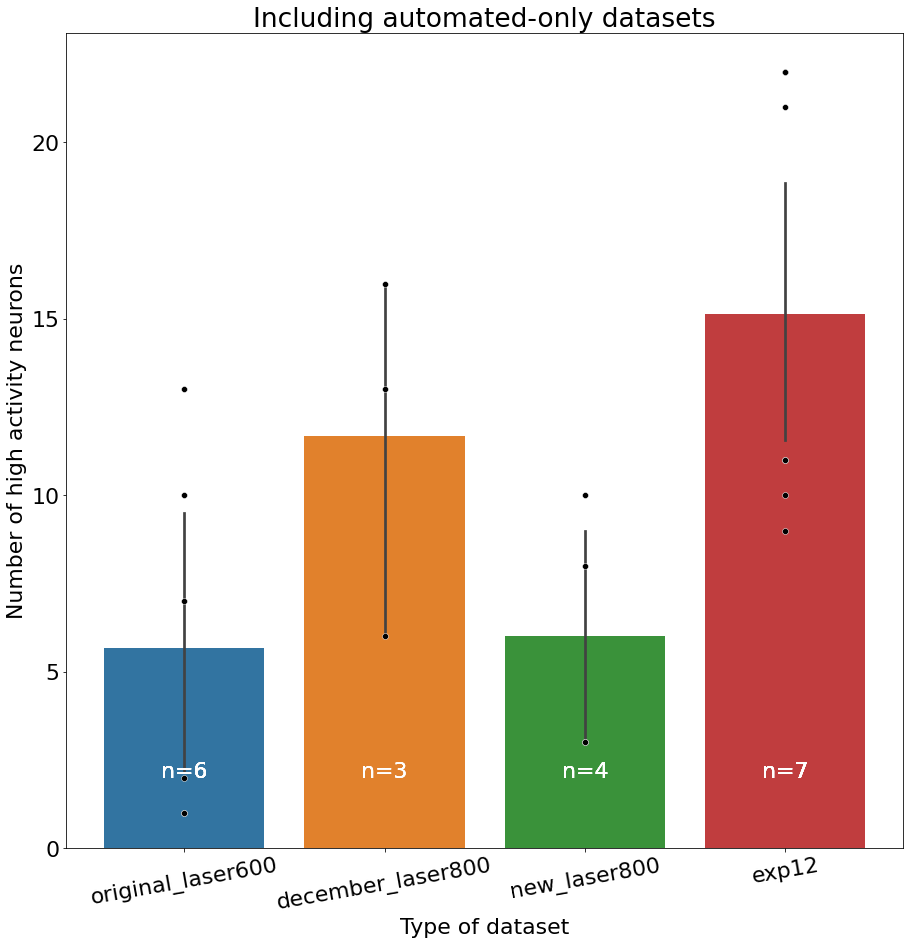

In [78]:
plt.figure(figsize=(15, 15))

to_plot = 'high'
df = df_all

ax = sns.barplot(data=df, y=to_plot, x='title')
for index, row in df.iterrows():
    ax.text(row.title, 2, f"n={(df['title'] == row.title).value_counts()[True]}",
            color='white', ha='center')
    
sns.scatterplot(data=df, y=to_plot, x='title', legend=False, zorder=10, color='k')
plt.xlabel("Type of dataset")
plt.xticks(rotation=10)
plt.ylabel(f"Number of {to_plot} activity neurons")
plt.title("Including automated-only datasets")

plt.savefig('hardware_quantifications/dataset_types_high_activity.png')

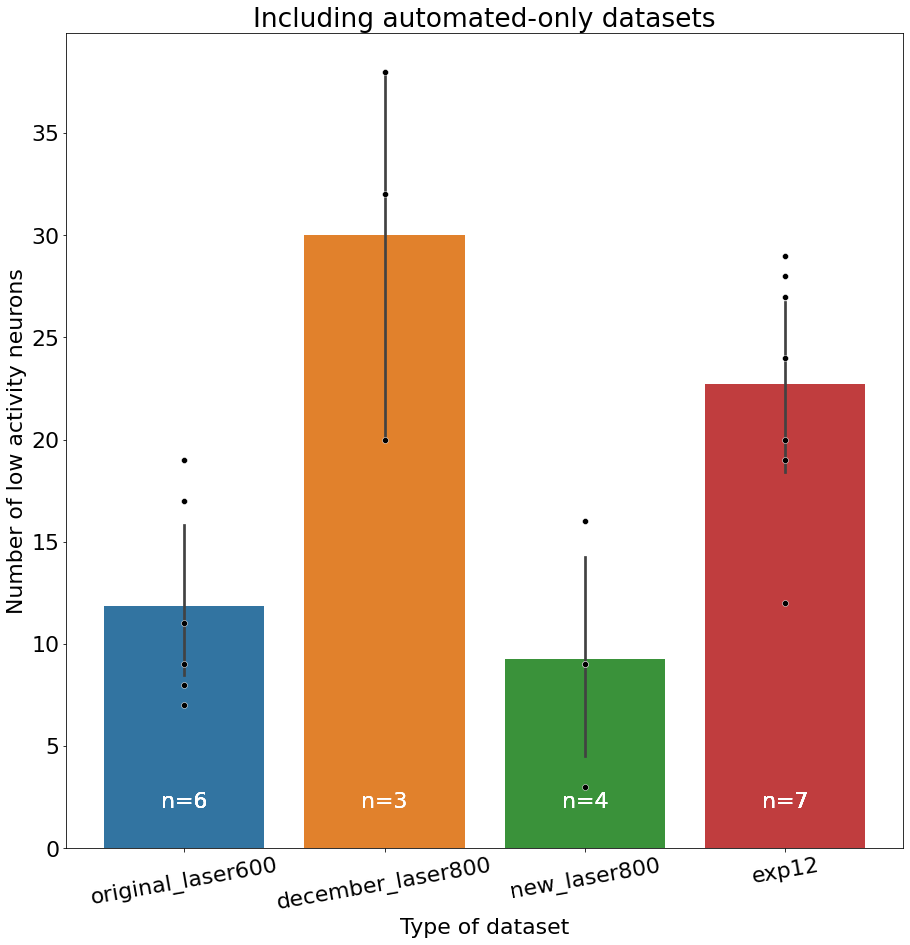

In [79]:
plt.figure(figsize=(15, 15))

to_plot = 'low'
df = df_all

ax = sns.barplot(data=df, y=to_plot, x='title')
for index, row in df.iterrows():
    ax.text(row.title, 2, f"n={(df['title'] == row.title).value_counts()[True]}",
            color='white', ha='center')
    
sns.scatterplot(data=df, y=to_plot, x='title', legend=False, zorder=10, color='k')
plt.xlabel("Type of dataset")
plt.xticks(rotation=10)
plt.ylabel(f"Number of {to_plot} activity neurons")
plt.title("Including automated-only datasets")

plt.savefig('hardware_quantifications/dataset_types_low_activity.png')

<Figure size 1080x1080 with 0 Axes>

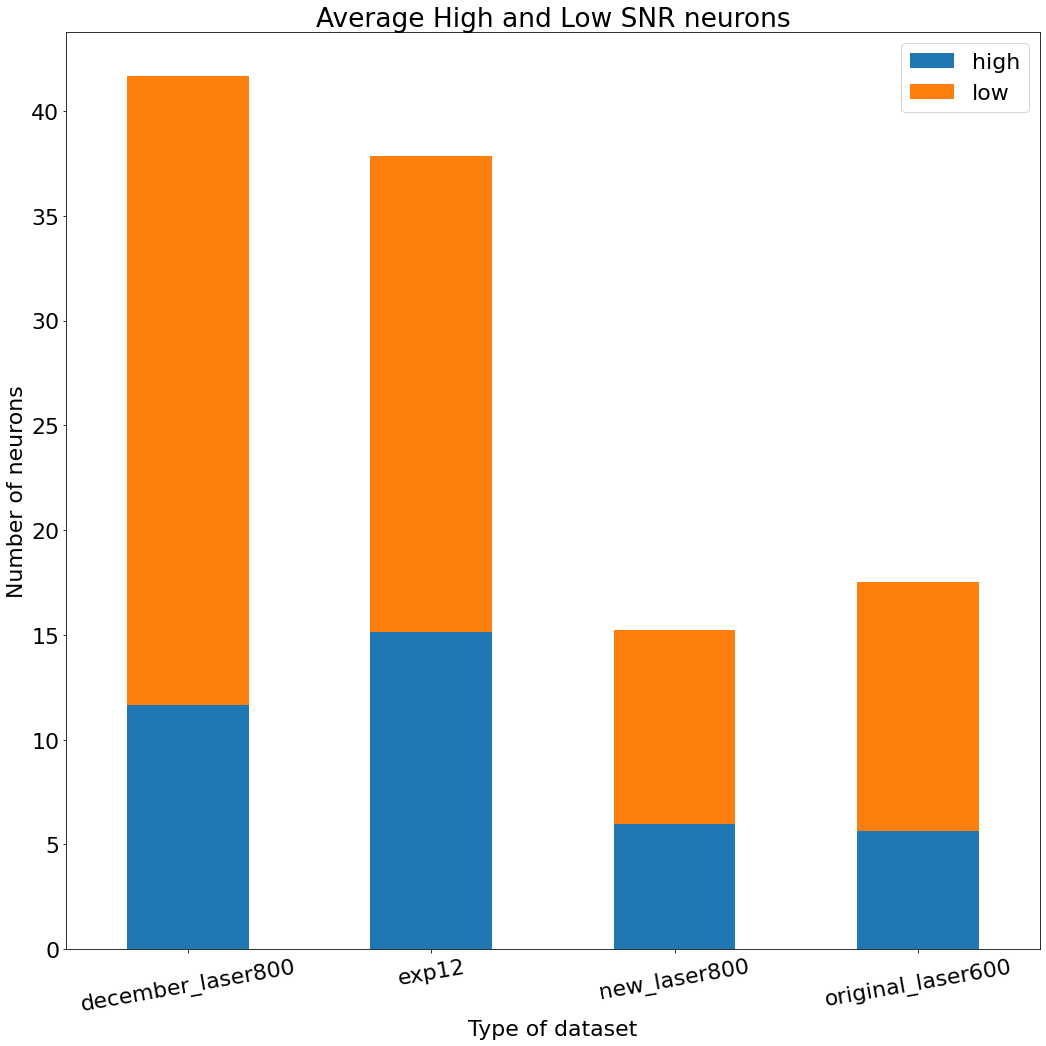

In [80]:
plt.figure(figsize=(15, 15))

to_plot = 'low'
df = df_all

df_to_plot = df.drop(columns=['possible']).groupby('title')
df_to_plot.mean().plot(kind='bar', stacked=True, figsize=(15,15))

plt.xlabel("Type of dataset")
plt.ylabel(f"Number of neurons")
plt.title("Average High and Low SNR neurons")
plt.xticks(rotation=10)

plt.tight_layout()
plt.savefig('hardware_quantifications/dataset_types_high_low_stacked_activity.png')

# Include new gcamps

In [45]:
df_all = pd.concat([df_dim_all, df_bright_all, df_bright_new, df_exp12, df_2gcamp_6ms, df_2gcamp_12ms, df_gcamp7b, df_gcamp7b_spacer])

to_save = True

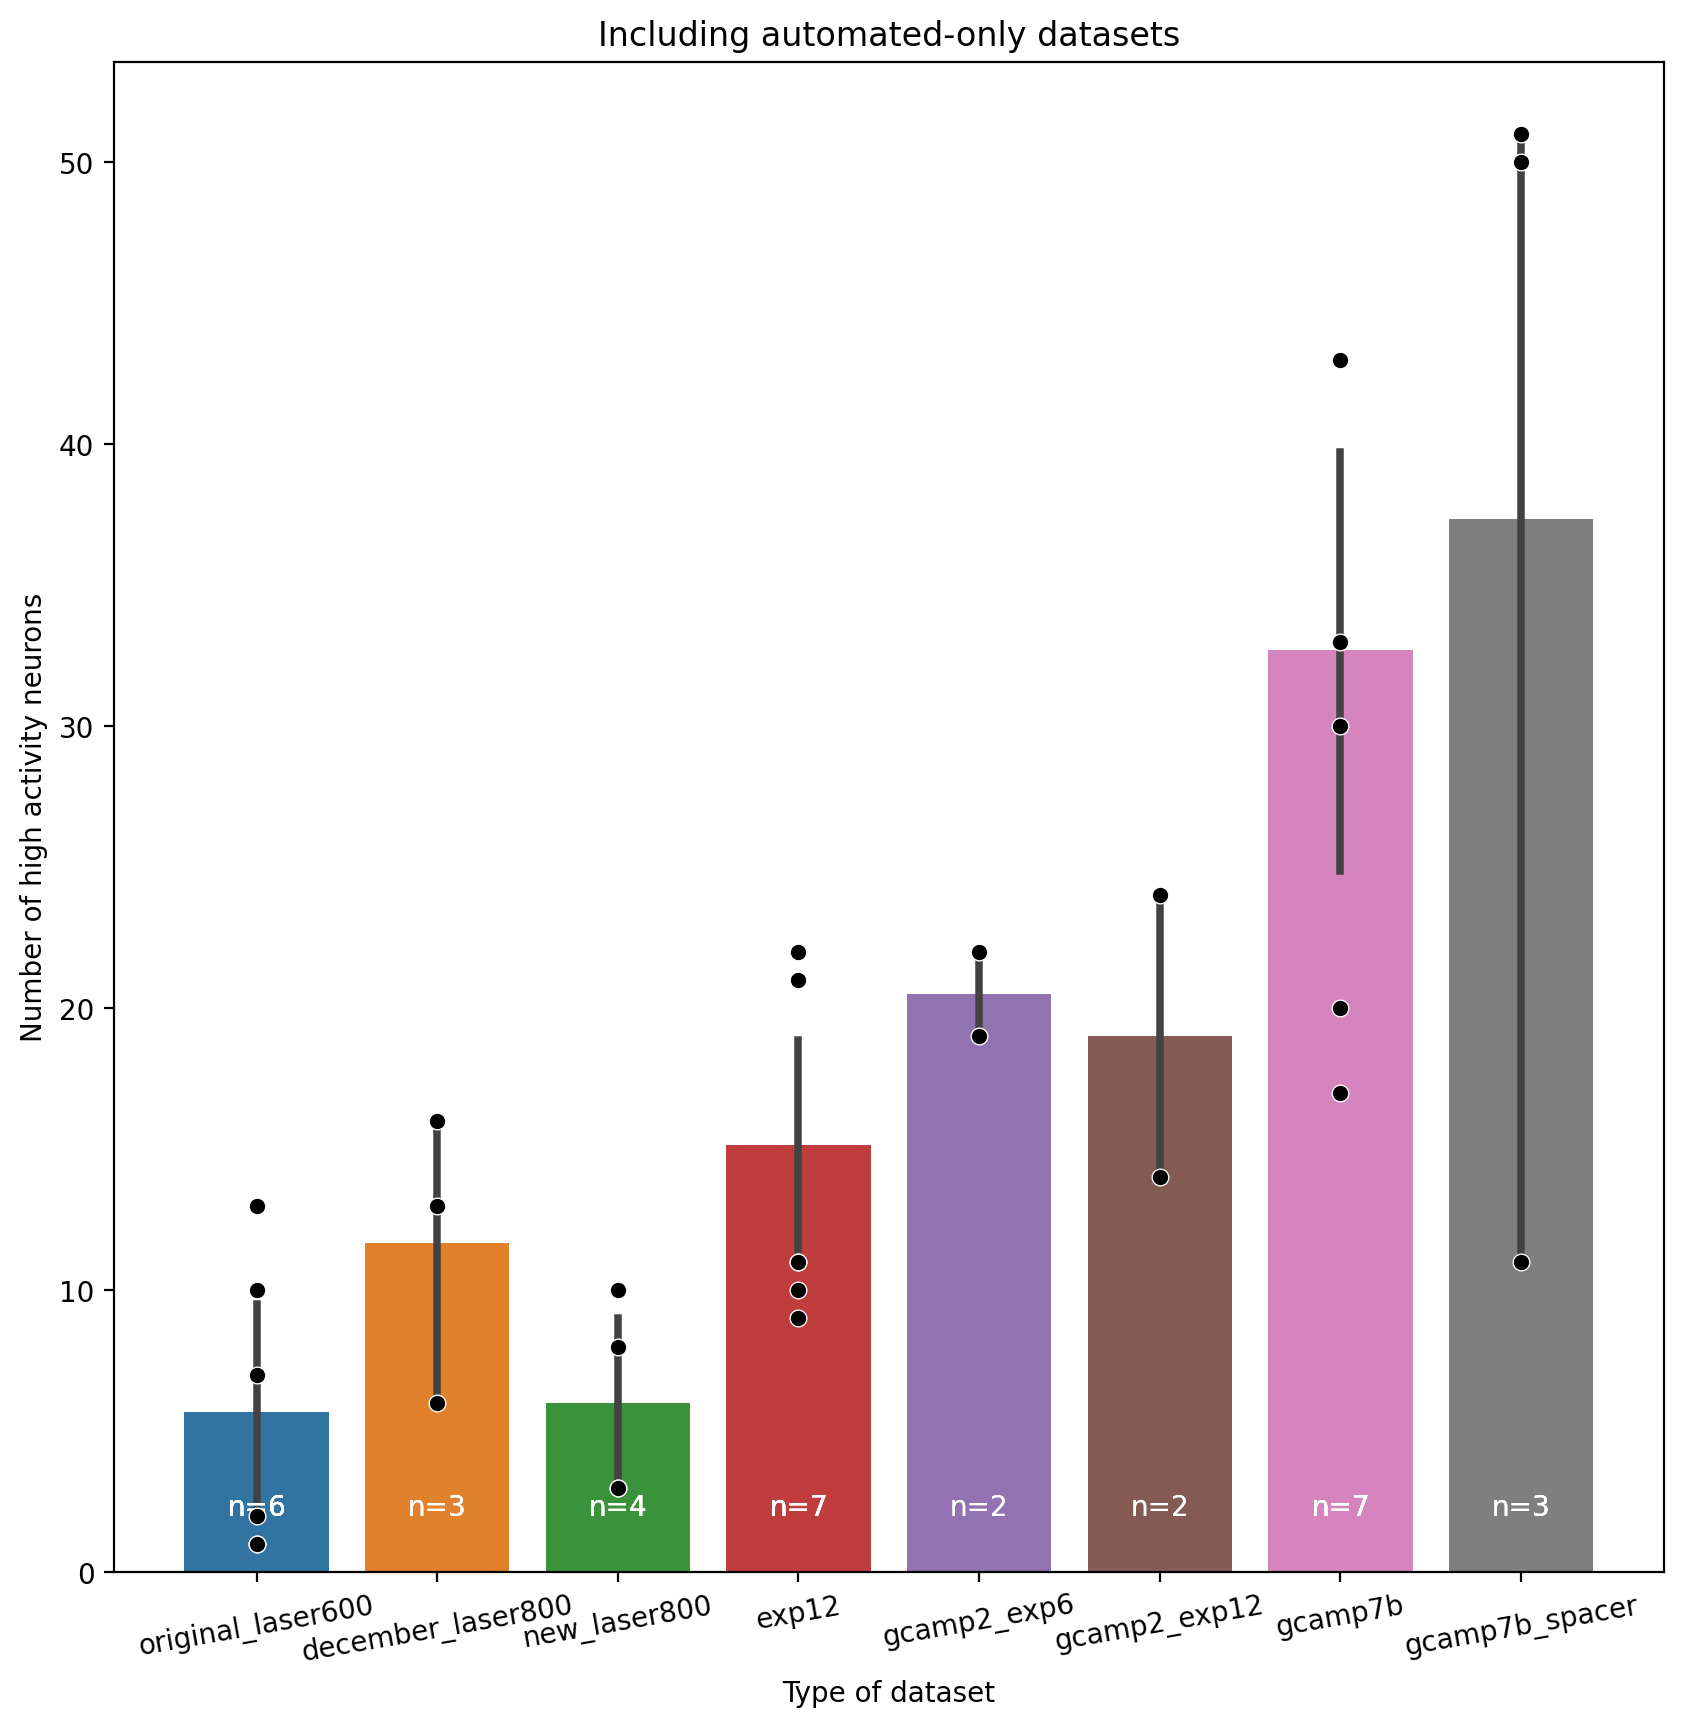

In [46]:
plt.figure(figsize=(10, 10), dpi=200)

to_plot = 'high'
df = df_all

ax = sns.barplot(data=df, y=to_plot, x='title')
for index, row in df.iterrows():
    ax.text(row.title, 2, f"n={(df['title'] == row.title).value_counts()[True]}",
            color='white', ha='center')
    
sns.scatterplot(data=df, y=to_plot, x='title', legend=False, zorder=10, color='k')
plt.xlabel("Type of dataset")
plt.xticks(rotation=10)
plt.ylabel(f"Number of {to_plot} activity neurons")
plt.title("Including automated-only datasets")

if to_save:
    plt.savefig('hardware_quantifications/dataset_types_high_activity_with_gcamp7b.png')

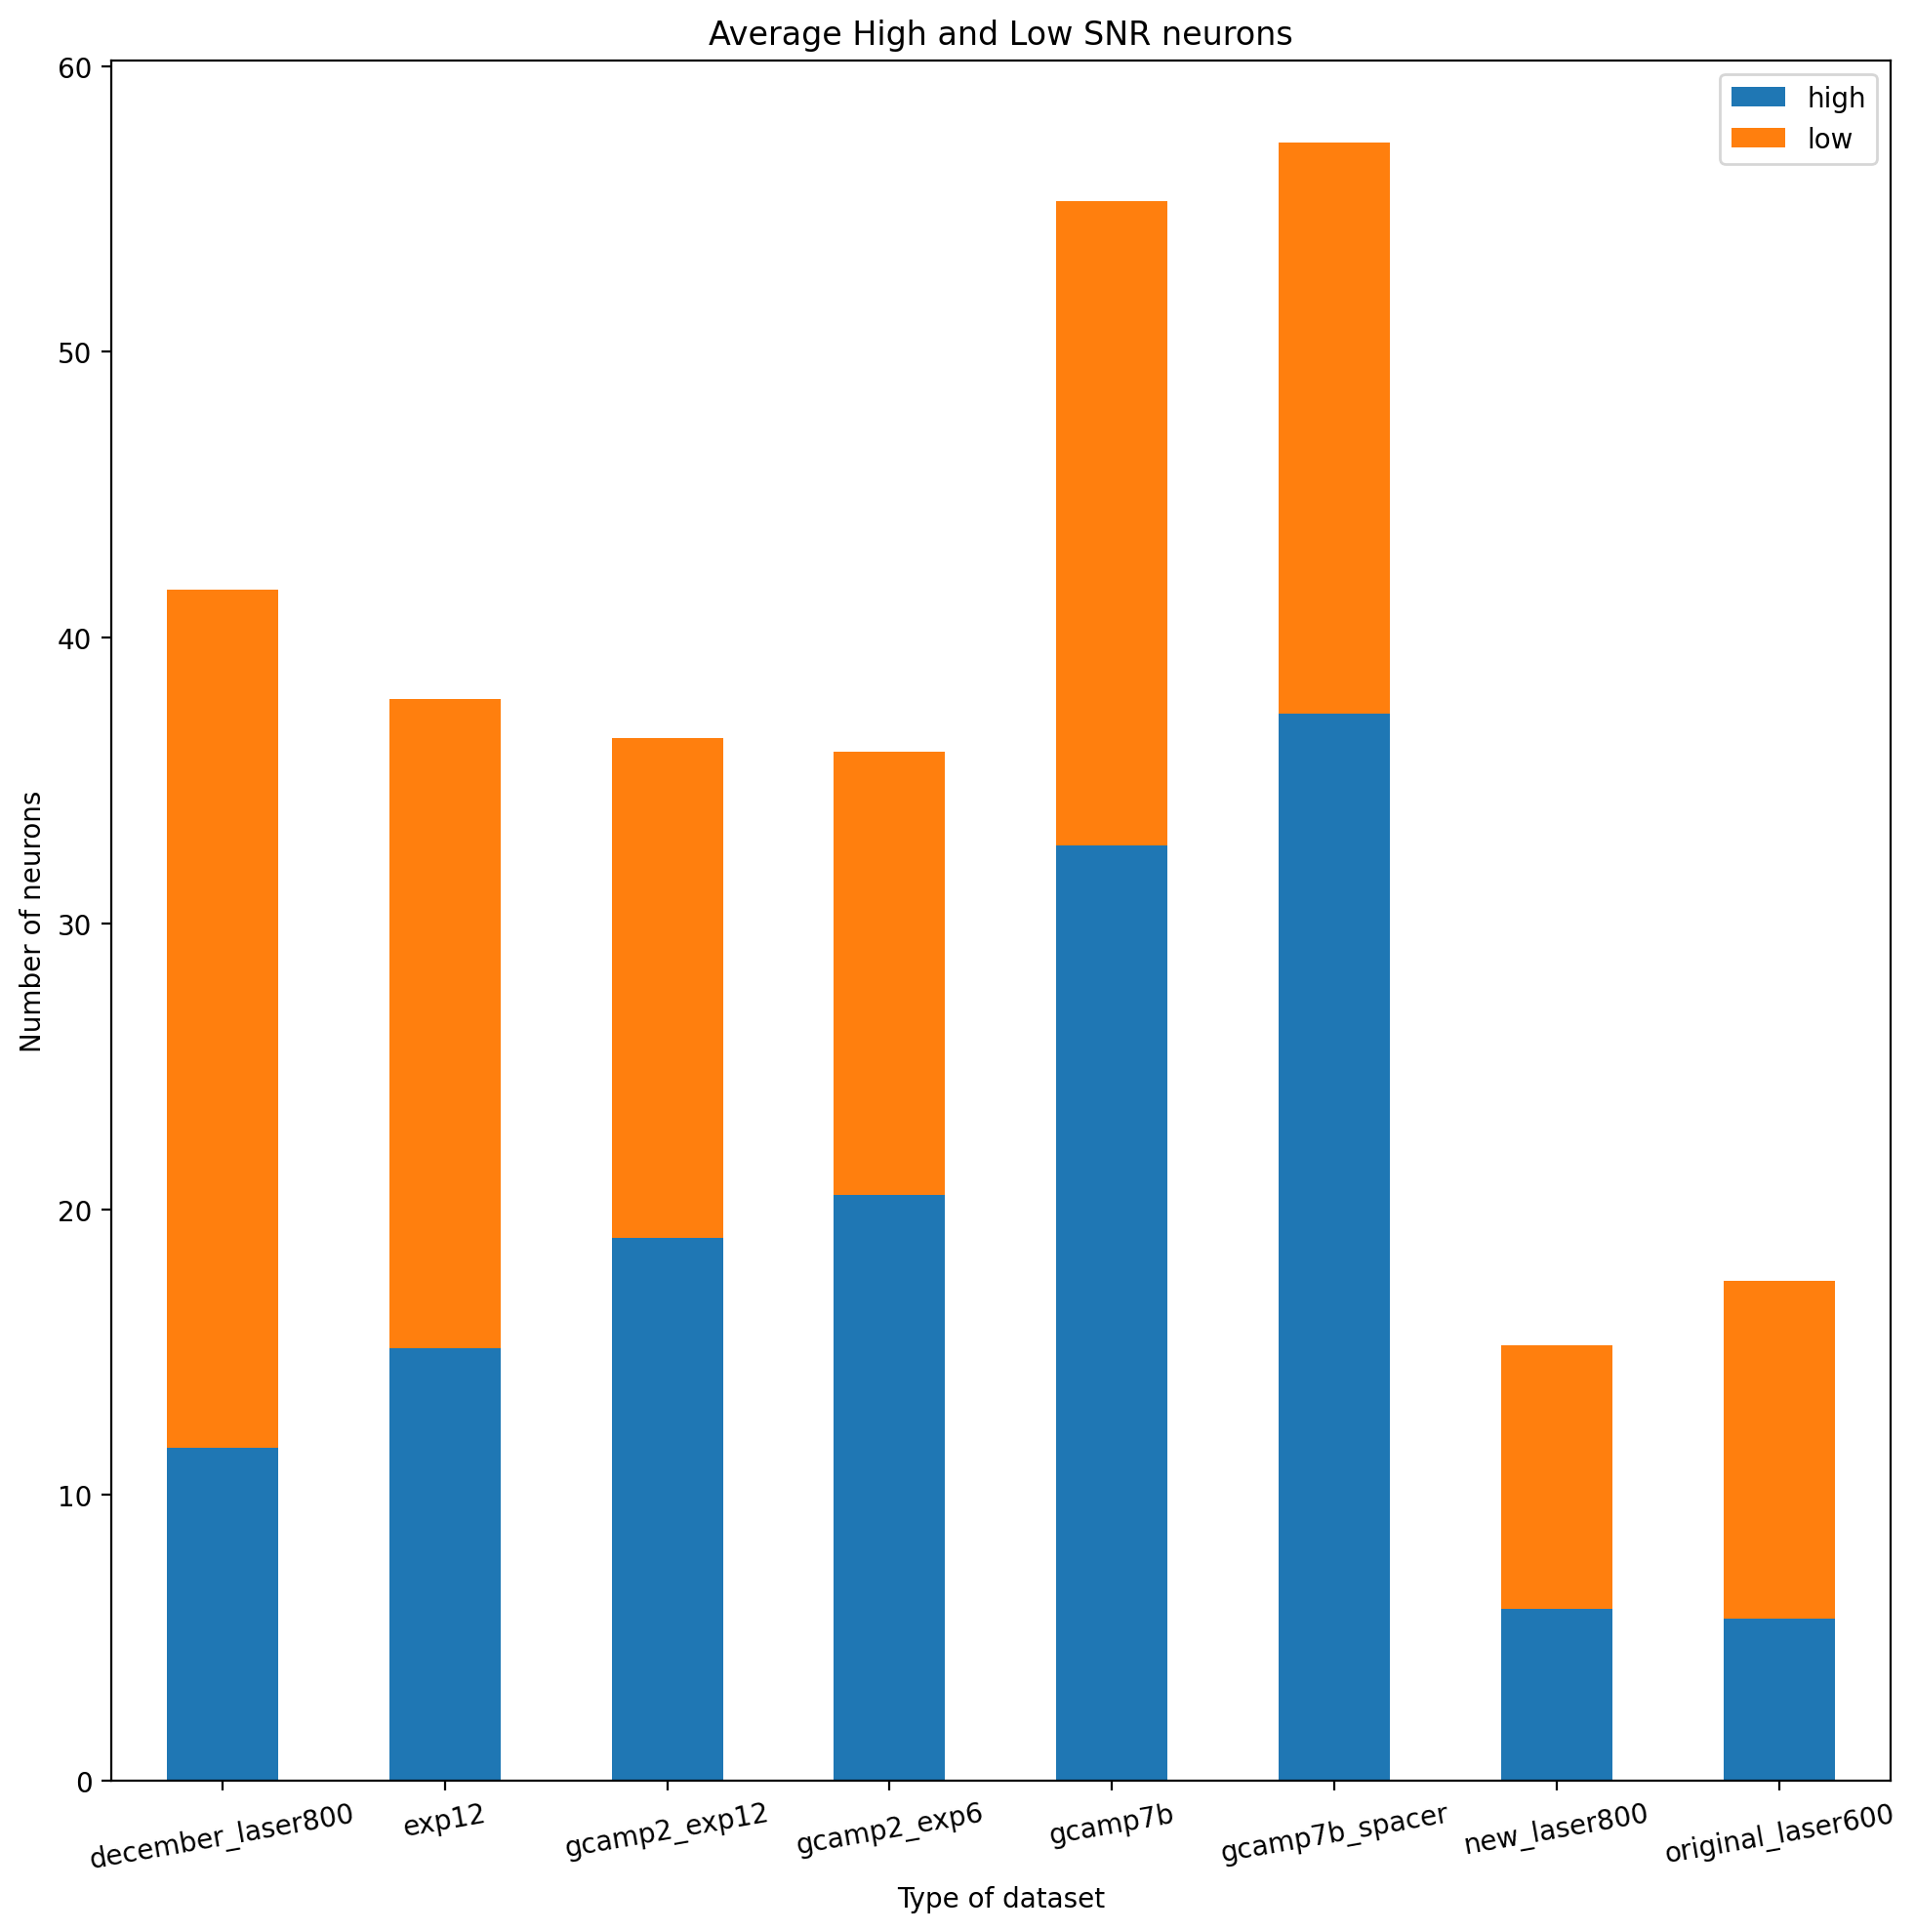

In [48]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=200)

to_plot = 'low'
df = df_all

df_to_plot = df.drop(columns=['possible']).groupby('title')
df_to_plot.mean().plot(kind='bar', stacked=True, ax=ax)

plt.xlabel("Type of dataset")
plt.ylabel(f"Number of neurons")
plt.title("Average High and Low SNR neurons")
plt.xticks(rotation=10)

plt.tight_layout()
if to_save:
    plt.savefig('hardware_quantifications/dataset_types_high_low_stacked_activity_gcamp7b.png')